# 欠拟合与过拟合

作为机器学习科学家，我们的目标是发现模式（pattern）。但是，我们如何才能确定模型是真正发现了一种泛化的模式，而不是简单地记住了数据呢？

将模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合（overfitting），用于对抗过拟合的技术称为正则化（regularization）。

在前面的章节中，我们可能在用Fashion‐MNIST数据集做实验时已经观察到了这种过拟合现象。在实验中调整模型架构或超参数时会发现：如果有足够多的神经元、层数和训练迭代周期，模型最终可以在训练集上达到完美的精度，此时测试集的准确性却下降了。

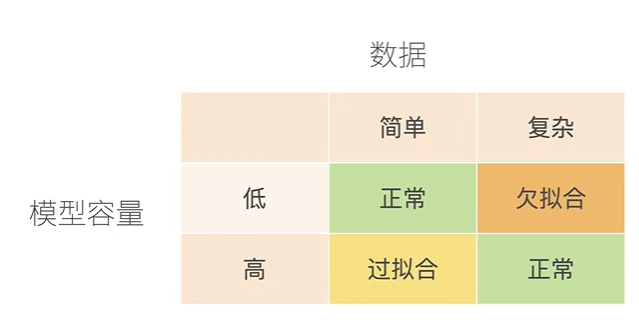

**模型容量**

- 拟合各种函数的能力
- 低容量的模型难以拟合训练数据
- 高容量的模型可以记住所有训练数据

**模型大小影响**

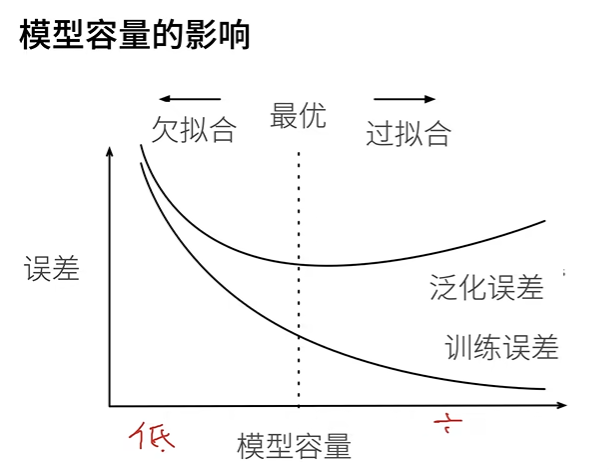

**估计模型容量**

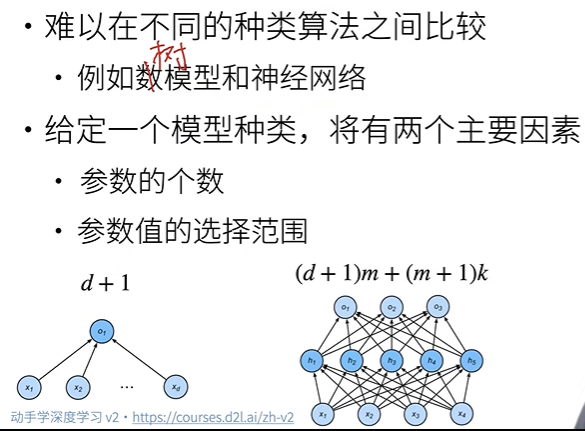



## 训练误差与训练泛化

为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。

- 训练误差（trainingerror）是指，模型在训练数据集上计算得到的误差。
- 泛化误差（generalizationerror）是指，模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

，我们永远不能准确地计算出泛化误差。这是因为无限多的数据样本是一个虚构的对象。在实际中，我们只能通过将模型应用于一个独立的测试集来估计泛化误差，该测试集由随机选取的、未曾在训练集中出现的数据样本构成

**统计学习理论(VC维)**

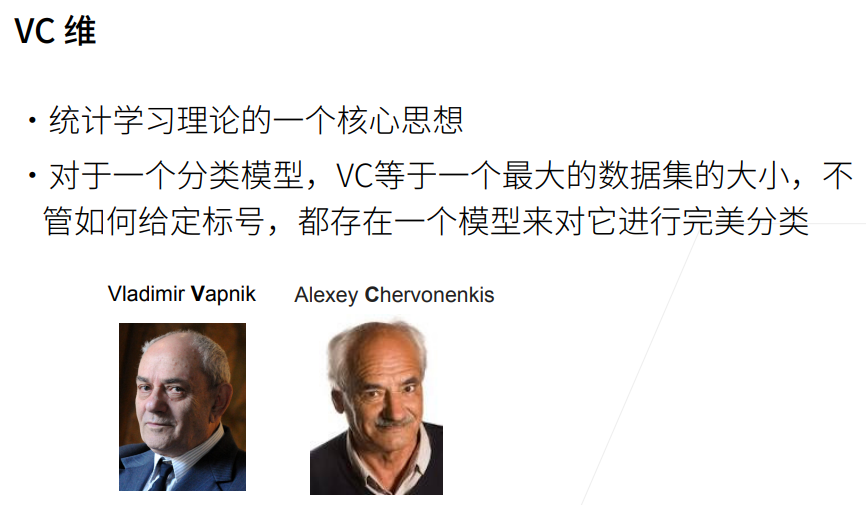

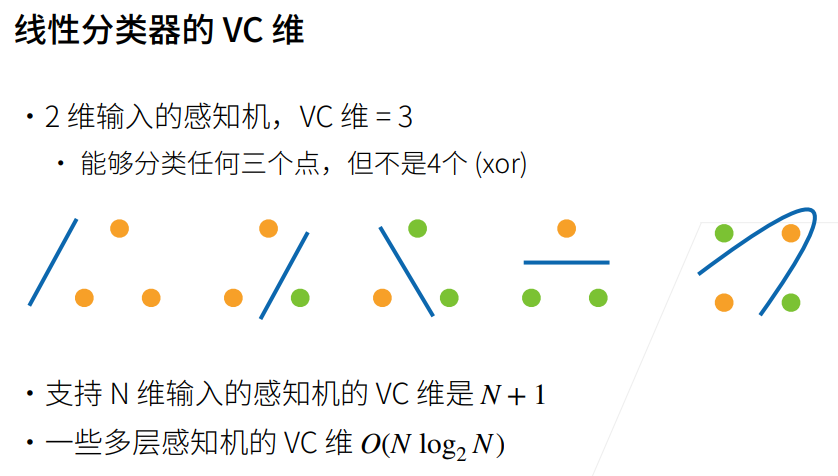

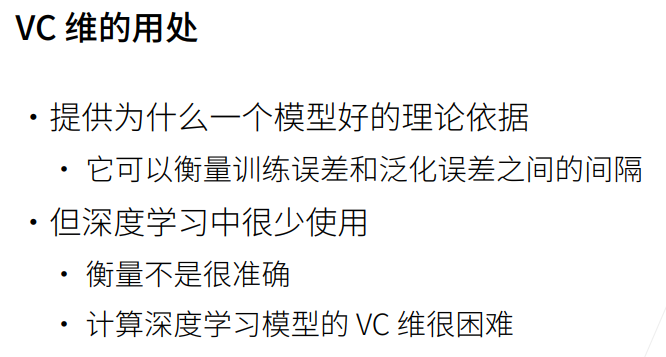

**数据复杂度**

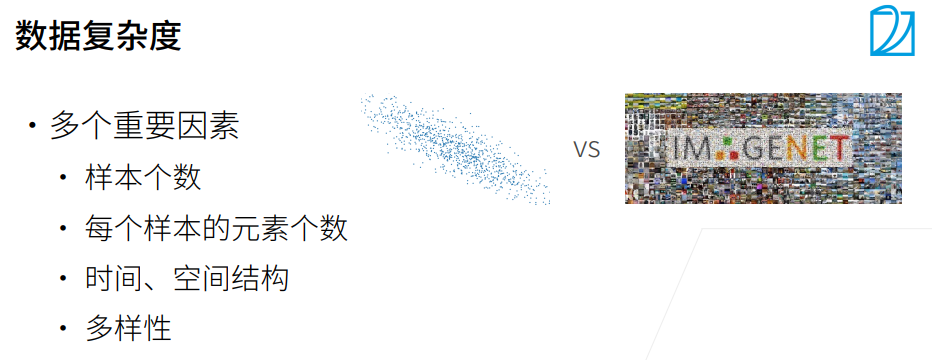

**总结**

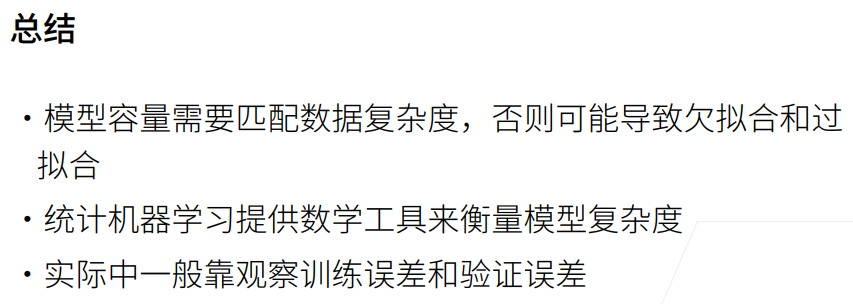



## 模型选择

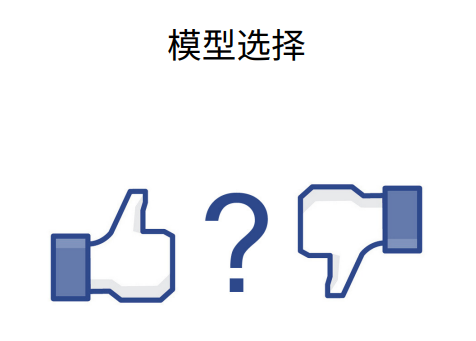

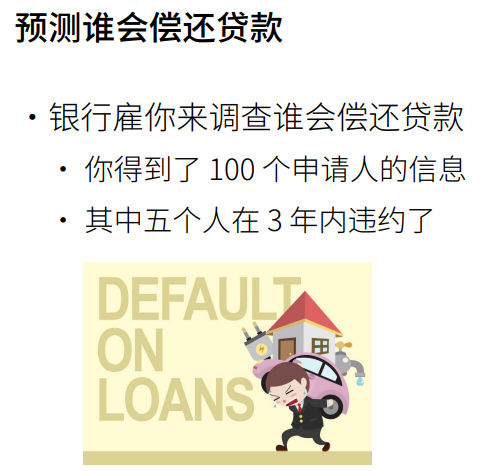

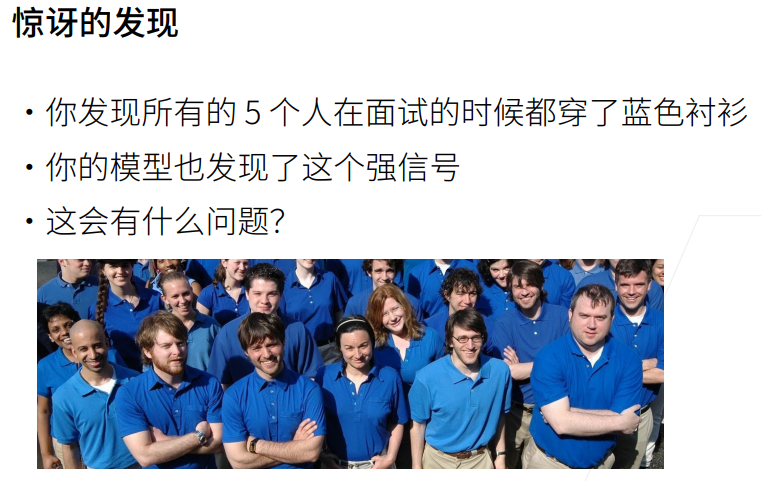

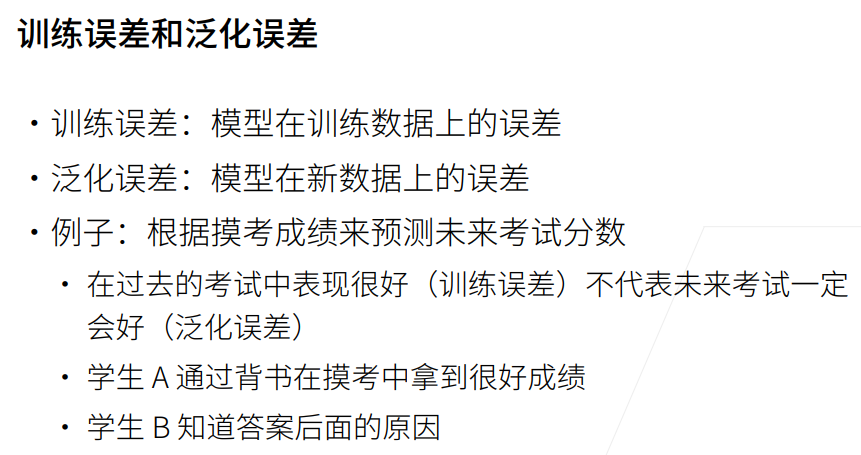

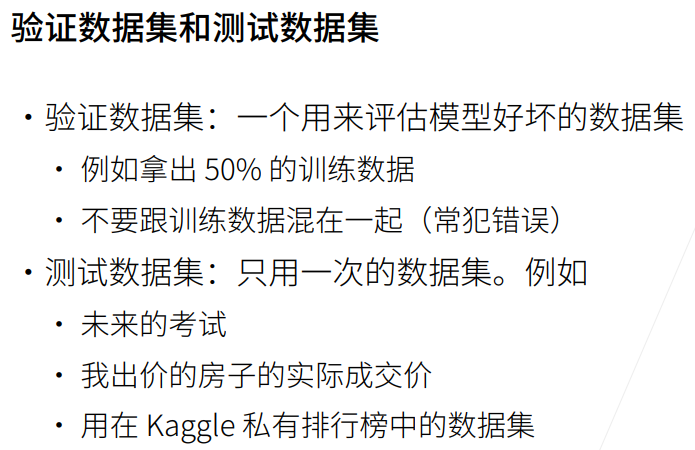

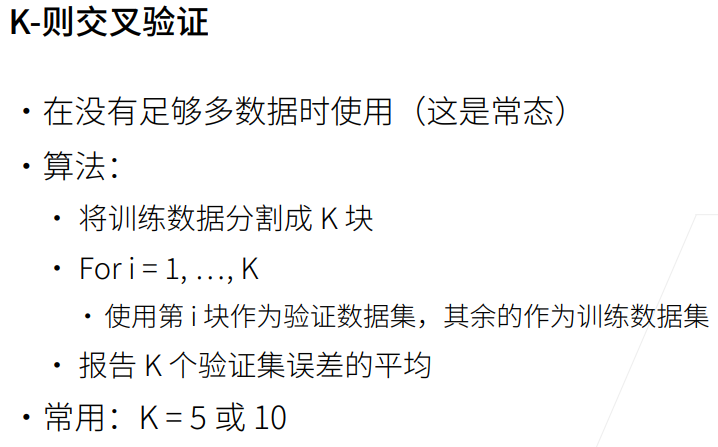

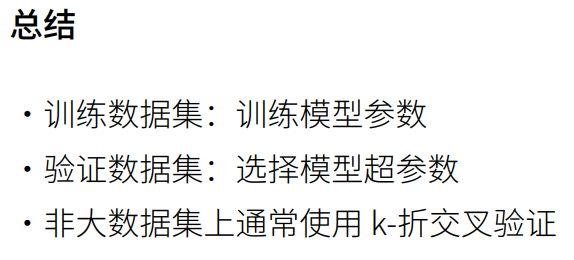

## 多项式回归

使用多项式拟合来探索这一些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，使用以下三阶多项式来生成训练和测试数据的标签：

$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).
$$

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.0285],
         [-0.3482]]),
 tensor([[ 1.0000e+00,  1.0285e+00,  5.2887e-01,  1.8131e-01,  4.6617e-02,
           9.5887e-03,  1.6436e-03,  2.4148e-04,  3.1044e-05,  3.5475e-06,
           3.6485e-07,  3.4112e-08,  2.9236e-09,  2.3129e-10,  1.6991e-11,
           1.1650e-12,  7.4884e-14,  4.5303e-15,  2.5885e-16,  1.4011e-17],
         [ 1.0000e+00, -3.4821e-01,  6.0625e-02, -7.0367e-03,  6.1256e-04,
          -4.2660e-05,  2.4757e-06, -1.2315e-07,  5.3604e-09, -2.0739e-10,
           7.2216e-12, -2.2860e-13,  6.6335e-15, -1.7768e-16,  4.4193e-18,
          -1.0259e-19,  2.2326e-21, -4.5731e-23,  8.8466e-25, -1.6213e-26]]),
 tensor([5.4539, 4.4318]))

### 对模型进行训练与测试

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合(正常情况)

weight: [[ 4.987368   1.1908154 -3.3810122  5.616418 ]]


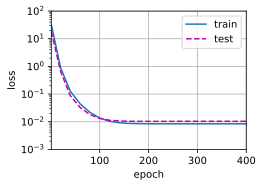

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合(欠拟合)

weight: [[2.5701911 5.3262467]]


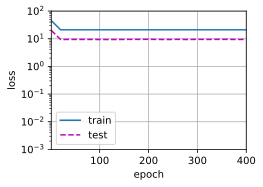

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式拟合(过拟合)

weight: [[ 5.002961    1.2490598  -3.448394    5.3361263   0.10789444  0.79481506
   0.32085556 -0.07691027  0.23160838  0.00854847  0.15220691 -0.1186691
   0.07308965  0.20686078 -0.04750184  0.07985986  0.21377522 -0.19952804
   0.18461242 -0.14636973]]


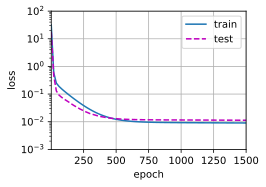

In [10]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 小结

- 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
- 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
- 验证集可以用于模型选择，但不能过于随意地使用它。
- 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。